<a href="https://colab.research.google.com/github/REALBroomFish/group-project/blob/main/Model_1_Training_and_Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialisation

In [ ]:
import os
import json
import random

import numpy as np
import pandas as pd
import torch

from dataclasses import dataclass

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

import seaborn as sns
import matplotlib.pyplot as plt

# Colab: mount Google Drive so we can load the JSONL splits
from google.colab import drive
drive.mount("/content/drive")

@dataclass
class Model1Config:
    data_dir: str = "/content/drive/MyDrive/Uni Stuff"

    train_path: str = None
    dev_path: str = None
    test_path: str = None

    seed: int = 67

    # TF-IDF / classical model hyperparams
    max_features: int = 20000
    ngram_min: int = 1
    ngram_max: int = 2
    logreg_C: float = 1.0
    svm_C: float = 1.0

    def __post_init__(self):
        if self.train_path is None:
            self.train_path = os.path.join(self.data_dir, "tempowic_train.jsonl")
        if self.dev_path is None:
            self.dev_path = os.path.join(self.data_dir, "tempowic_validation.jsonl")
        if self.test_path is None:
            self.test_path = os.path.join(self.data_dir, "tempowic_test.jsonl")


def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def load_tempo_wic_split(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(f"TempoWiC split not found at: {path}")

    df = pd.read_json(path, lines=True)

    required_cols = {"gold_label_binary", "text_1", "text_2", "target"}
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing expected columns in {path}: {missing}")

    df = df.copy()
    df["label"] = df["gold_label_binary"].astype(int)
    return df


# global init
cfg = Model1Config()
set_seed(cfg.seed)

print("Config:")
print(cfg)

print("\nLoading TempoWiC splits...")
train_df = load_tempo_wic_split(cfg.train_path)
dev_df = load_tempo_wic_split(cfg.dev_path)
test_df = load_tempo_wic_split(cfg.test_path)

print("Train size:", len(train_df))
print("Dev size:", len(dev_df))
print("Test size:", len(test_df))
print("Columns:", train_df.columns.tolist())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Config:
Model1Config(data_dir='/content/drive/MyDrive/Uni Stuff', train_path='/content/drive/MyDrive/Uni Stuff/tempowic_train.jsonl', dev_path='/content/drive/MyDrive/Uni Stuff/tempowic_validation.jsonl', test_path='/content/drive/MyDrive/Uni Stuff/tempowic_test.jsonl', seed=67, max_features=20000, ngram_min=1, ngram_max=2, logreg_C=1.0, svm_C=1.0)

Loading TempoWiC splits...
Train size: 1427
Dev size: 395
Test size: 1472
Columns: ['gold_label_binary', 'text_1', 'text_start_1', 'text_end_1', 'date_1', 'text_1_tokenized', 'text_2', 'text_start_2', 'text_end_2', 'date_2', 'text_2_tokenized', 'target', 'label']


# Basic descriptive analysis for model 2

Train examples: 1427
Dev examples:   395
Test examples:  1472

Label distribution (train):
  0: 777 examples
  1: 650 examples


/tmp/ipython-input-2091970854.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts_train.index.astype(str), y=label_counts_train.values, palette="viridis")


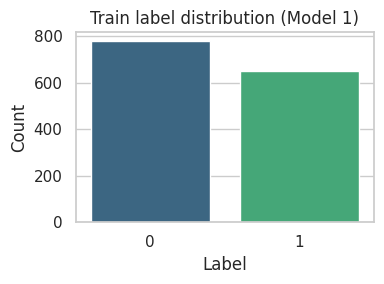


Random train examples (for sanity):

Text 1: I officially hace a au The name of it is Arístale Au were frisk was able to change one thing in the past. The change led to many events changing. Like for example gaster will be around. Its basically a au were everyone has a second chance at life.
Text 2: I was personally stopped at least there's times under Bloomberg's stop and frisk policy. They never found anything but I was still a target. #BloombergIsRacist
Target: frisk
Label: 0
--------------------------------------------------------------------------------
Text 1: To @JewishVoice: A picture of Jews murdered in German camp #BergenBelsen to depict Polish pogrom at #Jedwabne. Unacceptable. "Nazi Germany chose to locate its death camps in Poland, ostensibly because of rabid anti-Semitism in pre-war Poland" - utter ignorance. @user
Text 2: I wonder people did what @narendramodi said them to do. So the pogrom of Delhi muslims ..... Rest you know.
Target: pogrom
Label: 1
------------------

In [ ]:
# === Basic descriptive analysis for Model 1 ===

sns.set_theme(style="whitegrid")

print(f"Train examples: {len(train_df)}")
print(f"Dev examples:   {len(dev_df)}")
print(f"Test examples:  {len(test_df)}")

# label distribution (0 = same sense? / different sense? depending on organisers)
label_counts_train = train_df["label"].value_counts().sort_index()
label_counts_dev   = dev_df["label"].value_counts().sort_index()

print("\nLabel distribution (train):")
for label, count in label_counts_train.items():
    print(f"  {label}: {count} examples")

plt.figure(figsize=(4, 3))
sns.barplot(x=label_counts_train.index.astype(str), y=label_counts_train.values, palette="viridis")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Train label distribution (Model 1)")
plt.tight_layout()
plt.show()

print("\nRandom train examples (for sanity):\n")
for _, row in train_df.sample(n=3, random_state=cfg.seed).iterrows():
    print("Text 1:", row["text_1"])
    print("Text 2:", row["text_2"])
    print("Target:", row["target"])
    print("Label:", row["label"])
    print("-" * 80)

# simple majority-class baseline on dev (useful reference point)
majority_label = label_counts_train.idxmax()
print(f"\nMajority label in train: {majority_label}")

y_dev_majority = np.full(shape=len(dev_df), fill_value=majority_label, dtype=int)
y_dev_true = dev_df["label"].to_numpy()

maj_acc = accuracy_score(y_dev_true, y_dev_majority)
maj_prec, maj_rec, maj_f1, _ = precision_recall_fscore_support(
    y_dev_true, y_dev_majority, average="macro", zero_division=0
)

print("\nMajority baseline on dev:")
print(f"  accuracy:      {maj_acc:.4f}")
print(f"  macro_precision: {maj_prec:.4f}")
print(f"  macro_recall:    {maj_rec:.4f}")
print(f"  macro_f1:        {maj_f1:.4f}")


## Combined text construction for Model 1

In [ ]:
def build_combined_text(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["combined_text"] = df.apply(
        lambda row: f"Tweet1: {row['text_1']} Tweet2: {row['text_2']} Target: {row['target']}",
        axis=1,
    )
    return df

train_df_m1 = build_combined_text(train_df)
dev_df_m1   = build_combined_text(dev_df)
test_df_m1  = build_combined_text(test_df)

print("Model 1 data shapes:")
print("  Train:", train_df_m1.shape)
print("  Dev:  ", dev_df_m1.shape)
print("  Test: ", test_df_m1.shape)

print("\nExample combined texts (train):")
for _, row in train_df_m1.sample(n=3, random_state=cfg.seed).iterrows():
    print("  Text:", row["combined_text"])
    print("  Label:", row["label"])
    print("-" * 80)


Model 1 data shapes:
  Train: (1427, 14)
  Dev:   (395, 14)
  Test:  (1472, 14)

Example combined texts (train):
  Text: Tweet1: I officially hace a au The name of it is Arístale Au were frisk was able to change one thing in the past. The change led to many events changing. Like for example gaster will be around. Its basically a au were everyone has a second chance at life. Tweet2: I was personally stopped at least there's times under Bloomberg's stop and frisk policy. They never found anything but I was still a target. #BloombergIsRacist Target: frisk
  Label: 0
--------------------------------------------------------------------------------
  Text: Tweet1: To @JewishVoice: A picture of Jews murdered in German camp #BergenBelsen to depict Polish pogrom at #Jedwabne. Unacceptable. "Nazi Germany chose to locate its death camps in Poland, ostensibly because of rabid anti-Semitism in pre-war Poland" - utter ignorance. @user Tweet2: I wonder people did what @narendramodi said them to do. S

## Metrics for Model 1

In [ ]:

def classification_metrics(y_true, y_pred):
    """
    Compute accuracy + macro precision/recall/F1.
    Macro-F1 is the main figure of merit (as in the shared task).
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    return {
        "accuracy": acc,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1,
    }


def print_report(y_true, y_pred):
    """
    Detailed classification report + confusion matrix for error analysis.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    print("Classification report (per class):")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)


# quick sanity check with random predictions
if len(train_df_m1) > 0:
    sample = train_df_m1.sample(n=min(100, len(train_df_m1)), random_state=cfg.seed)
    y_true_sample = sample["label"].to_numpy()
    rng = np.random.default_rng(cfg.seed)
    y_pred_sample = rng.integers(low=0, high=2, size=len(sample))

    metrics_random = classification_metrics(y_true_sample, y_pred_sample)
    print("\nSanity-check metrics on random predictions:")
    for k, v in metrics_random.items():
        print(f"  {k}: {v:.3f}")



Sanity-check metrics on random predictions:
  accuracy: 0.500
  precision_macro: 0.501
  recall_macro: 0.501
  f1_macro: 0.500


## TF-IDF representation for Model 1

In [ ]:

# raw texts
X_train_text = train_df_m1["combined_text"].tolist()
X_dev_text = dev_df_m1["combined_text"].tolist()
X_test_text = test_df_m1["combined_text"].tolist()

# labels
y_train = train_df_m1["label"].to_numpy()
y_dev = dev_df_m1["label"].to_numpy()
y_test = test_df_m1["label"].to_numpy()  # assuming test also has gold labels

tfidf = TfidfVectorizer(ngram_range=(cfg.ngram_min, cfg.ngram_max), min_df=2, max_features=cfg.max_features)

# fit on train, transform all splits
X_train = tfidf.fit_transform(X_train_text)
X_dev = tfidf.transform(X_dev_text)
X_test = tfidf.transform(X_test_text)

print("TF-IDF shapes:")
print("  Train:", X_train.shape)
print("  Dev:", X_dev.shape)
print("  Test:", X_test.shape)


TF-IDF shapes:
  Train: (1427, 11576)
  Dev: (395, 11576)
  Test: (1472, 11576)


# Model 1a: TF-IDF + Logistic Regression

In [ ]:
# Classical discriminative baseline: no pretrained embeddings, just bag-of-words features.

logreg = LogisticRegression(
    penalty="l2",
    C=cfg.logreg_C,
    class_weight="balanced",   # helps counter label skew
    max_iter=5000,
    n_jobs=-1,
    solver="liblinear",        # robust for sparse high-dimensional features
)

logreg.fit(X_train, y_train)
print("Model 1a (LogReg) training finished.")

# dev predictions
y_dev_pred_logreg = logreg.predict(X_dev)

m1a_dev_metrics = classification_metrics(y_dev, y_dev_pred_logreg)
print("\nModel 1a (TF-IDF + Logistic Regression) dev metrics:")
for k, v in m1a_dev_metrics.items():
    print(f"  {k}: {v:.4f}")

print("\nDetailed classification report (dev, Model 1a):")
print_report(y_dev, y_dev_pred_logreg)


Model 1a (LogReg) training finished.

Model 1a (TF-IDF + Logistic Regression) dev metrics:
  accuracy: 0.5139
  precision_macro: 0.5151
  recall_macro: 0.5154
  f1_macro: 0.5123

Detailed classification report (dev, Model 1a):
Classification report (per class):
              precision    recall  f1-score   support

           0      0.582     0.504     0.541       224
           1      0.448     0.526     0.484       171

    accuracy                          0.514       395
   macro avg      0.515     0.515     0.512       395
weighted avg      0.524     0.514     0.516       395

Confusion matrix:
 [[113 111]
 [ 81  90]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


# Model 1b: TF-IDF + LinearSVC

In [ ]:
linsvm = LinearSVC(C=cfg.svm_C, class_weight="balanced")

linsvm.fit(X_train, y_train)
print("Model 1b (LinearSVC) training finished.")

# dev predictions
y_dev_pred_svm = linsvm.predict(X_dev)

m1b_dev_metrics = classification_metrics(y_dev, y_dev_pred_svm)
print("\nModel 1b (TF-IDF + LinearSVC) dev metrics:")
for k, v in m1b_dev_metrics.items():
    print(f"  {k}: {v:.4f}")

print("\nDetailed classification report (dev, Model 1b):")
print_report(y_dev, y_dev_pred_svm)


Model 1b (LinearSVC) training finished.

Model 1b (TF-IDF + LinearSVC) dev metrics:
  accuracy: 0.4861
  precision_macro: 0.4792
  recall_macro: 0.4791
  f1_macro: 0.4790

Detailed classification report (dev, Model 1b):
Classification report (per class):
              precision    recall  f1-score   support

           0      0.548     0.531     0.540       224
           1      0.410     0.427     0.418       171

    accuracy                          0.486       395
   macro avg      0.479     0.479     0.479       395
weighted avg      0.489     0.486     0.487       395

Confusion matrix:
 [[119 105]
 [ 98  73]]


# Model 1 dev comparison

In [ ]:

summary_rows = []

row_a = {"model": "Model 1a (LogReg)"}
row_a.update(m1a_dev_metrics)
summary_rows.append(row_a)

row_b = {"model": "Model 1b (LinearSVC)"}
row_b.update(m1b_dev_metrics)
summary_rows.append(row_b)

summary_df = pd.DataFrame(summary_rows)

print("Model 1 dev comparison (macro metrics):")
display(summary_df[["model", "accuracy", "precision_macro", "recall_macro", "f1_macro"]])


Model 1 dev comparison (macro metrics):


,model,accuracy,precision_macro,recall_macro,f1_macro
0,Model 1a (LogReg),0.513924,0.515118,0.515390,0.51227
1,Model 1b (LinearSVC),0.486076,0.479250,0.479075,0.47901


# Final Model 1 Eval

In [ ]:
final_model = logreg

y_test_pred = final_model.predict(X_test)

m1_test_metrics = classification_metrics(y_test, y_test_pred)
print("Final Model 1 (classical baseline) test metrics:")
for k, v in m1_test_metrics.items():
    print(f"  {k}: {v:.4f}")

print("\nDetailed classification report (test, final Model 1):")
print_report(y_test, y_test_pred)


Final Model 1 (classical baseline) test metrics:
  accuracy: 0.4939
  precision_macro: 0.4988
  recall_macro: 0.4987
  f1_macro: 0.4870

Detailed classification report (test, final Model 1):
Classification report (per class):
              precision    recall  f1-score   support

           0      0.633     0.481     0.547       934
           1      0.364     0.517     0.427       538

    accuracy                          0.494      1472
   macro avg      0.499     0.499     0.487      1472
weighted avg      0.535     0.494     0.503      1472

Confusion matrix:
 [[449 485]
 [260 278]]


In [ ]:
# === Error analysis for final Model 1 ===

# we assume `final_model` is your chosen Model 1 (e.g. logreg)
# and train/dev/test_df_m1 still exist with `combined_text` and `label`

# add predictions to the test dataframe
test_df_errors = test_df_m1.copy()
test_df_errors["pred_label"] = y_test_pred
test_df_errors["correct"] = (test_df_errors["label"] == test_df_errors["pred_label"])

print("Test set size:", len(test_df_errors))
print("Correct predictions:", test_df_errors["correct"].sum())
print("Incorrect predictions:", (~test_df_errors["correct"]).sum())

# split into error types
fp_mask = (test_df_errors["label"] == 0) & (test_df_errors["pred_label"] == 1)
fn_mask = (test_df_errors["label"] == 1) & (test_df_errors["pred_label"] == 0)

fp_df = test_df_errors[fp_mask]  # predicted same meaning when it's actually different
fn_df = test_df_errors[fn_mask]  # predicted different meaning when it's actually same

print("\nFalse positives (gold 0, pred 1):", len(fp_df))
print("False negatives (gold 1, pred 0):", len(fn_df))


Test set size: 1472
Correct predictions: 727
Incorrect predictions: 745

False positives (gold 0, pred 1): 485
False negatives (gold 1, pred 0): 260


In [ ]:
# inspect a few random false positives and false negatives

def show_examples(df, n=5, seed=67, title=""):
    print(f"\n=== {title} (n={min(n, len(df))}) ===")
    if len(df) == 0:
        print("No examples.")
        return
    sample = df.sample(n=min(n, len(df)), random_state=seed)
    for _, row in sample.iterrows():
        print("Text 1:", row["text_1"])
        print("Text 2:", row["text_2"])
        print("Target:", row["target"])
        print(f"Gold label: {row['label']}  Predicted: {row['pred_label']}  Correct: {row['correct']}")
        print("-" * 80)

show_examples(fp_df, n=5, title="False positives (gold 0, pred 1)")
show_examples(fn_df, n=5, title="False negatives (gold 1, pred 0)")



=== False positives (gold 0, pred 1) (n=5) ===
Text 1: does ur dad ever come home with an unlabeled glass jar of bee pollen and when questioned about where he got it he just says “a guy who sells bee pollen”
Text 2: unlabeled people are so valid
Target: unlabeled
Gold label: 0  Predicted: 1  Correct: False
--------------------------------------------------------------------------------
Text 1: beat pyre for the first time last night three supergiant games i've played so far, and each one has been unexpected, amazing, and incredible ✨
Text 2: Let's keep this pyre burning even in our minds and heart to remind us that we have to kick these fascists out when OUR time comes that is to VOTE. People tend to forget but we won't this time!! Long live democracy, Long live India❤️✊🏽
Target: pyre
Gold label: 0  Predicted: 1  Correct: False
--------------------------------------------------------------------------------
Text 1: Enlightening. Feel disappointed with andy burnham seemingly in the poc

In [ ]:
# Save a few representative FP/FN examples for the report
fp_sample = fp_df.sample(n=min(10, len(fp_df)), random_state=cfg.seed)
fn_sample = fn_df.sample(n=min(10, len(fn_df)), random_state=cfg.seed)

error_examples = pd.concat([
    fp_sample.assign(error_type="FP (gold 0, pred 1)"),
    fn_sample.assign(error_type="FN (gold 1, pred 0)"),
])

err_out_path = "/content/drive/MyDrive/Uni Stuff/model1_error_examples.csv"
error_examples.to_csv(err_out_path, index=False)
print("Saved error examples to:", err_out_path)


Saved error examples to: /content/drive/MyDrive/Uni Stuff/model1_error_examples.csv


In [ ]:
# majority baseline on test (for comparison)
label_counts_train = train_df["label"].value_counts().sort_index()
majority_label = label_counts_train.idxmax()
y_test_true = y_test
y_test_majority = np.full_like(y_test_true, fill_value=majority_label)

maj_test_metrics = classification_metrics(y_test_true, y_test_majority)

# Build summary table
results_summary = pd.DataFrame([
    {
        "model": "Majority baseline",
        "split": "test",
        **maj_test_metrics,
    },
    {
        "model": "Model 1 (TF-IDF + LogReg)",
        "split": "test",
        **m1_test_metrics,
    },
])

results_summary


,model,split,accuracy,precision_macro,recall_macro,f1_macro
0,Majority baseline,test,0.634511,0.317255,0.500000,0.388196
1,Model 1 (TF-IDF + LogReg),test,0.493886,0.498819,0.498728,0.486962
